<a href="https://colab.research.google.com/github/shubhamcodez/quant-strategies/blob/main/Fama_French_Risk_factor_modelling_Bitcoin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fama French Risk Factor Modelling for Bitcoin

## Introduction
The Fama-French three-factor model is a widely used asset pricing model that extends the Capital Asset Pricing Model (CAPM) by incorporating two additional risk factors: size and value. This notebook applies the Fama-French risk factor modelling technique to Bitcoin, exploring its suitability for this cryptocurrency.

## Objectives
1.   Load and prepare Bitcoin price data
2.   Calculate the Fama-French risk factors (market, size, and value)
3. Estimate the three-factor model for Bitcoin
4. Analyze the results and discuss implications

### Note
This notebook is for educational purposes only and should not be considered as investment advice. Cryptocurrencies, including Bitcoin, are highly volatile and subject to significant risks. <br>
Let's get started!

# Fama French Factor model

$$R_{Bitcoin} - R_f = \alpha + \beta (R_m - R_f) + \sigma SMB + h HML$$

Where: <br> <br>
* $R_{Bitcoin}$ is the return of Bitcoin
* $R_f$ is the risk-free rate (e.g. 3-month Treasury bill rate)
* $\alpha$ is the intercept or constant term
* $\beta$ is the market risk premium (MRP)
* $R_m$ is the market return (e.g. S&P 500 index)
* $\sigma$ is the size risk premium (SMB)
* $h$ is the value risk premium (HML)
* SMB is the size factor (e.g. small-cap minus large-cap returns)
* HML is the value factor (e.g. high-book-to-market minus low-book-to-market returns)

### Importing Libraries

In [1]:
import yfinance as yf
import pandas as pd
import datetime as dt
import numpy as np
import pandas_datareader as pdr
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Get Bitcoin price data
bitcoin_data = yf.Ticker("BTC-USD")

# Get historical price data for bitcoin
historical_data = pd.DataFrame(bitcoin_data.history(period="max", interval = "1wk")['Close'])
historical_data.index = historical_data.index.strftime('%Y-%m-%d')
historical_data.head()

,Close
Date,
2014-09-15,398.821014
2014-09-22,377.181000
2014-09-29,320.510010
2014-10-06,378.549011
2014-10-13,389.545990


In [3]:
start = '2014-09-10'
start

'2014-09-10'

In [4]:
#pdr.famafrench.get_available_datasets()

In [5]:
factor_data = pdr.famafrench.FamaFrenchReader('F-F_Research_Data_Factors_weekly', start=start).read()[0]
momentum_factor = pdr.famafrench.FamaFrenchReader('F-F_Momentum_Factor_daily', freq = 'W', start=start).read()[0]
momentum_factor.columns = momentum_factor.columns.str.replace(' ', '')

<ipython-input-5-ce3fb75cd78b>:1: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  factor_data = pdr.famafrench.FamaFrenchReader('F-F_Research_Data_Factors_weekly', start=start).read()[0]
<ipython-input-5-ce3fb75cd78b>:2: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  momentum_factor = pdr.famafrench.FamaFrenchReader('F-F_Momentum_Factor_daily', freq = 'W', start=start).read()[0]


In [6]:
factor_data["mom"] = momentum_factor["Mom"]
factor_data.head(5)

,Mkt-RF,SMB,HML,RF,mom
Date,,,,,
2014-09-12,-0.86,0.59,-0.53,0.0,-0.42
2014-09-19,0.90,-2.32,0.36,0.0,0.01
2014-09-26,-1.58,-0.73,-0.93,0.0,0.59
2014-10-03,-0.79,-0.39,-0.78,0.0,0.46
2014-10-10,-3.58,-1.43,0.53,0.0,-0.38


In [7]:
factor_data.reset_index(inplace=True)
factor_data = factor_data.drop("Date",axis = 1)
historical_data.reset_index(inplace=True)

factor_data.head()

,Mkt-RF,SMB,HML,RF,mom
0,-0.86,0.59,-0.53,0.0,-0.42
1,0.90,-2.32,0.36,0.0,0.01
2,-1.58,-0.73,-0.93,0.0,0.59
3,-0.79,-0.39,-0.78,0.0,0.46
4,-3.58,-1.43,0.53,0.0,-0.38


In [8]:
data = pd.concat([factor_data, historical_data], axis=1)
data["returns"] = data["Close"].pct_change()
data = data.dropna()
data.head()

,Mkt-RF,SMB,HML,RF,mom,Date,Close,returns
1,0.90,-2.32,0.36,0.0,0.01,2014-09-22,377.181000,-0.054260
2,-1.58,-0.73,-0.93,0.0,0.59,2014-09-29,320.510010,-0.150249
3,-0.79,-0.39,-0.78,0.0,0.46,2014-10-06,378.549011,0.181083
4,-3.58,-1.43,0.53,0.0,-0.38,2014-10-13,389.545990,0.029050
5,-0.51,3.60,-0.84,0.0,1.06,2014-10-20,354.704010,-0.089443


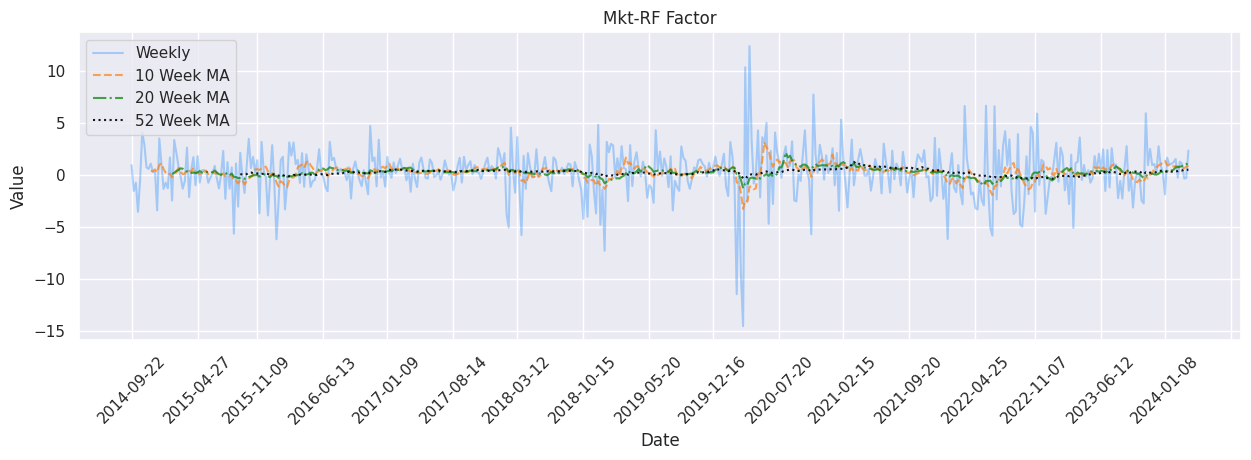

In [9]:
import matplotlib.ticker as ticker
import matplotlib.dates as mdates

sns.set()
plt.figure(figsize=(15, 4))

# Weekly data
sns.lineplot(data=data, x=data["Date"], y='Mkt-RF', label='Weekly', linestyle='-', alpha=0.3, color='#007bff')  # Blue

# 10 week moving average
sns.lineplot(data=data, x=data["Date"], y=data['Mkt-RF'].rolling(10).mean(), label='10 Week MA', linestyle='--', alpha=0.7, color='#ff7f0e')  # Orange

# 20 week moving average
sns.lineplot(data=data, x=data["Date"], y=data['Mkt-RF'].rolling(20).mean(), label='20 Week MA', linestyle='-.', alpha=0.7, color='green')  # green

# 52 week moving average
sns.lineplot(data=data, x=data["Date"], y=data['Mkt-RF'].rolling(52).mean(), label='52 Week MA', linestyle=':', alpha=0.9, color='black')  # black

plt.title('Mkt-RF Factor')
plt.xlabel('Date')
plt.ylabel('Value')

# Plot x axis as 1 month ticks
xaxis_months = mdates.MonthLocator(interval=1)
plt.gca().xaxis.set_major_locator(xaxis_months)

# Rotate x-axis labels 45 degrees
plt.gca().xaxis.set_tick_params(rotation=45)

# Add legend
plt.legend(loc='upper left')

plt.show()

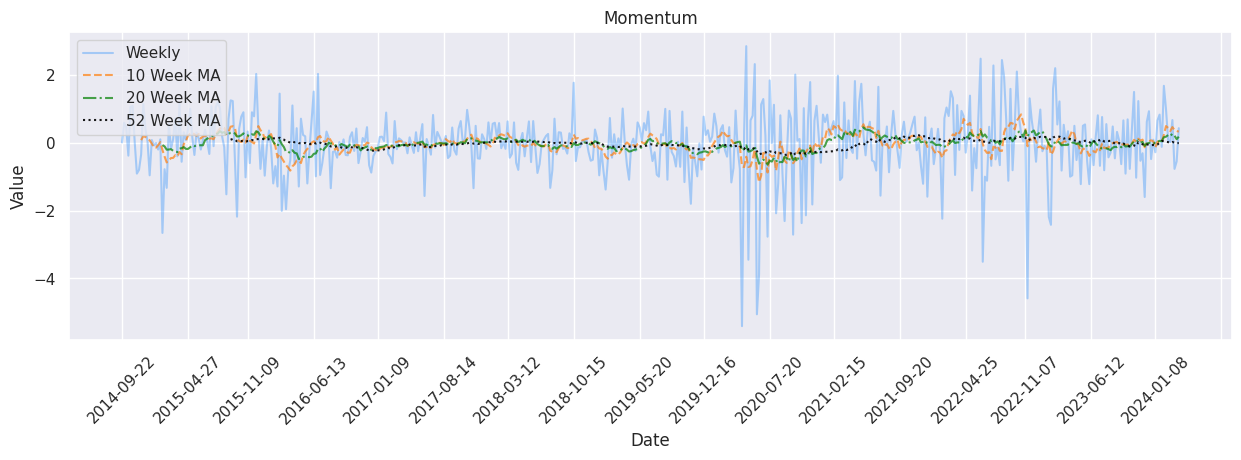

In [10]:
import matplotlib.ticker as ticker
import matplotlib.dates as mdates

sns.set()
plt.figure(figsize=(15, 4))

# Weekly data
sns.lineplot(data=data, x=data["Date"], y='mom', label='Weekly', linestyle='-', alpha=0.3, color='#007bff')  # Blue

# 10 week moving average
sns.lineplot(data=data, x=data["Date"], y=data['mom'].rolling(10).mean(), label='10 Week MA', linestyle='--', alpha=0.7, color='#ff7f0e')  # Orange

# 20 week moving average
sns.lineplot(data=data, x=data["Date"], y=data['mom'].rolling(20).mean(), label='20 Week MA', linestyle='-.', alpha=0.7, color='green')  # green

# 52 week moving average
sns.lineplot(data=data, x=data["Date"], y=data['mom'].rolling(52).mean(), label='52 Week MA', linestyle=':', alpha=0.9, color='black')  # black

plt.title('Momentum')
plt.xlabel('Date')
plt.ylabel('Value')

# Plot x axis as 1 month ticks
xaxis_months = mdates.MonthLocator(interval=1)
plt.gca().xaxis.set_major_locator(xaxis_months)

# Rotate x-axis labels 45 degrees
plt.gca().xaxis.set_tick_params(rotation=45)

# Add legend
plt.legend(loc='upper left')

plt.show()

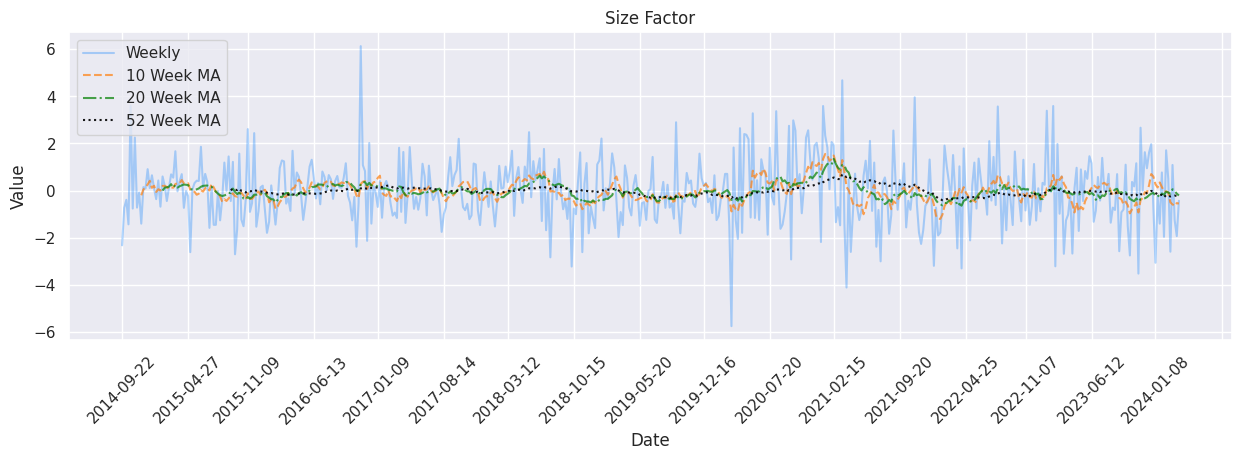

In [11]:
import matplotlib.ticker as ticker
import matplotlib.dates as mdates

sns.set()
plt.figure(figsize=(15, 4))

# Weekly data
sns.lineplot(data=data, x=data["Date"], y='SMB', label='Weekly', linestyle='-', alpha=0.3, color='#007bff')  # Blue

# 10 week moving average
sns.lineplot(data=data, x=data["Date"], y=data['SMB'].rolling(10).mean(), label='10 Week MA', linestyle='--', alpha=0.7, color='#ff7f0e')  # Orange

# 20 week moving average
sns.lineplot(data=data, x=data["Date"], y=data['SMB'].rolling(20).mean(), label='20 Week MA', linestyle='-.', alpha=0.7, color='green')  # green

# 52 week moving average
sns.lineplot(data=data, x=data["Date"], y=data['SMB'].rolling(52).mean(), label='52 Week MA', linestyle=':', alpha=0.9, color='black')  # black

plt.title('Size Factor')
plt.xlabel('Date')
plt.ylabel('Value')

# Plot x axis as 1 month ticks
xaxis_months = mdates.MonthLocator(interval=1)
plt.gca().xaxis.set_major_locator(xaxis_months)

# Rotate x-axis labels 45 degrees
plt.gca().xaxis.set_tick_params(rotation=45)

# Add legend
plt.legend(loc='upper left')

plt.show()

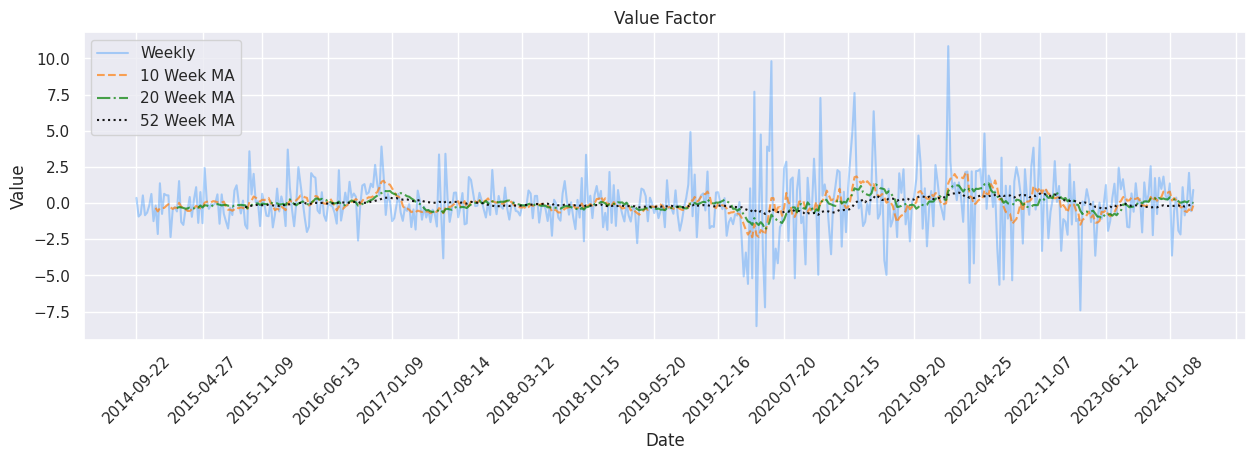

In [12]:
import matplotlib.ticker as ticker
import matplotlib.dates as mdates

sns.set()
plt.figure(figsize=(15, 4))

# Weekly data
sns.lineplot(data=data, x=data["Date"], y='HML', label='Weekly', linestyle='-', alpha=0.3, color='#007bff')  # Blue

# 10 week moving average
sns.lineplot(data=data, x=data["Date"], y=data['HML'].rolling(10).mean(), label='10 Week MA', linestyle='--', alpha=0.7, color='#ff7f0e')  # Orange

# 20 week moving average
sns.lineplot(data=data, x=data["Date"], y=data['HML'].rolling(20).mean(), label='20 Week MA', linestyle='-.', alpha=0.7, color='green')  # green

# 52 week moving average
sns.lineplot(data=data, x=data["Date"], y=data['HML'].rolling(52).mean(), label='52 Week MA', linestyle=':', alpha=0.9, color='black')  # black

plt.title('Value Factor')
plt.xlabel('Date')
plt.ylabel('Value')

# Plot x axis as 1 month ticks
xaxis_months = mdates.MonthLocator(interval=1)
plt.gca().xaxis.set_major_locator(xaxis_months)

# Rotate x-axis labels 45 degrees
plt.gca().xaxis.set_tick_params(rotation=45)

# Add legend
plt.legend(loc='upper left')

plt.show()

## Risk modelling on weekly data

In [13]:
data["bitcoin-RF"] = data["returns"] - data["RF"]

In [14]:
X = data[["Mkt-RF","mom", 'SMB', 'HML']]
y = data["bitcoin-RF"]

In [15]:
import statsmodels.api as sm

X = sm.add_constant(X)  # Add a constant (intercept) to the independent variables
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             bitcoin-RF   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                 -0.003
Method:                 Least Squares   F-statistic:                    0.5735
Date:                Fri, 24 May 2024   Prob (F-statistic):              0.682
Time:                        01:04:43   Log-Likelihood:                 416.67
No. Observations:                 497   AIC:                            -823.3
Df Residuals:                     492   BIC:                            -802.3
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0133      0.005     -2.800      0.0

## Risk modelling on 10 week averages

In [16]:
data_10wkMA = data.drop("Date",axis = 1).rolling(10).mean().dropna()
data_10wkMA.head()

,Mkt-RF,SMB,HML,RF,mom,Close,returns,bitcoin-RF
10,0.365,-0.198,-0.328,0.0,0.078,364.314801,-0.000646,-0.000646
11,0.301,0.049,-0.578,0.0,0.191,364.106201,0.003999,0.003999
12,0.488,0.131,-0.348,0.0,0.173,367.218399,0.012768,0.012768
13,0.223,0.261,-0.345,0.0,0.131,361.447797,-0.014096,-0.014096
14,0.928,0.415,-0.334,0.0,0.073,354.217099,-0.018124,-0.018124


In [17]:
data_10wkMA["bitcoin-RF"] = data_10wkMA["returns"] - data_10wkMA["RF"]

In [18]:
X = data_10wkMA[["Mkt-RF","mom", 'SMB', 'HML']]
y = data_10wkMA["bitcoin-RF"]

In [19]:
import statsmodels.api as sm

X = sm.add_constant(X)  # Add a constant (intercept) to the independent variables
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             bitcoin-RF   R-squared:                       0.131
Model:                            OLS   Adj. R-squared:                  0.123
Method:                 Least Squares   F-statistic:                     18.14
Date:                Fri, 24 May 2024   Prob (F-statistic):           6.83e-14
Time:                        01:04:43   Log-Likelihood:                 807.15
No. Observations:                 488   AIC:                            -1604.
Df Residuals:                     483   BIC:                            -1583.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0145      0.002     -6.323      0.0

## Risk modelling on 20 week averages

In [20]:
data_20wkMA = data.drop("Date",axis = 1).rolling(20).mean().dropna()
data_20wkMA.head()

,Mkt-RF,SMB,HML,RF,mom,Close,returns,bitcoin-RF
20,0.0455,0.0010,-0.3385,0.0,-0.0680,322.612651,-0.023019,-0.023019
21,0.1665,0.1275,-0.2805,0.0,-0.1075,315.494851,-0.017752,-0.017752
22,0.3505,0.1420,-0.2995,0.0,-0.2035,311.268201,-0.009994,-0.009994
23,0.4300,0.1685,-0.3360,0.0,-0.1985,305.350850,-0.013916,-0.013916
24,0.5995,0.2745,-0.3850,0.0,-0.1885,299.591251,-0.012649,-0.012649


In [21]:
data_20wkMA["bitcoin-RF"] = data_20wkMA["returns"] - data_20wkMA["RF"]

In [22]:
X = data_20wkMA[["Mkt-RF","mom", 'SMB', 'HML']]
y = data_20wkMA["bitcoin-RF"]

In [23]:
import statsmodels.api as sm

X = sm.add_constant(X)  # Add a constant (intercept) to the independent variables
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             bitcoin-RF   R-squared:                       0.184
Model:                            OLS   Adj. R-squared:                  0.177
Method:                 Least Squares   F-statistic:                     26.61
Date:                Fri, 24 May 2024   Prob (F-statistic):           6.36e-20
Time:                        01:04:43   Log-Likelihood:                 867.00
No. Observations:                 478   AIC:                            -1724.
Df Residuals:                     473   BIC:                            -1703.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0154      0.002     -7.055      0.0

## Risk modelling on 52 week averages

In [24]:
data_52wkMA = data.drop("Date",axis = 1).rolling(52).mean().dropna()
data_52wkMA.head()

,Mkt-RF,SMB,HML,RF,mom,Close,returns,bitcoin-RF
52,0.032308,0.016154,-0.255192,0.000154,0.089423,277.792578,-0.006871,-0.007025
53,0.012115,0.084231,-0.296154,0.000154,0.112885,275.015193,-0.005699,-0.005853
54,0.008462,0.046346,-0.209423,0.000154,0.091731,273.433443,-0.002355,-0.002509
55,0.037692,0.022308,-0.182885,0.000154,0.040962,270.904616,-0.005128,-0.005282
56,0.172692,0.080000,-0.154231,0.000154,0.056346,268.444943,-0.004551,-0.004705


In [25]:
data_52wkMA["bitcoin-RF"] = data_52wkMA["returns"] - data_52wkMA["RF"]

In [26]:
X = data_52wkMA[["Mkt-RF","mom", 'SMB', 'HML']]
y = data_52wkMA["bitcoin-RF"]

In [27]:
import statsmodels.api as sm

X = sm.add_constant(X)  # Add a constant (intercept) to the independent variables
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             bitcoin-RF   R-squared:                       0.352
Model:                            OLS   Adj. R-squared:                  0.346
Method:                 Least Squares   F-statistic:                     59.95
Date:                Fri, 24 May 2024   Prob (F-statistic):           2.05e-40
Time:                        01:04:43   Log-Likelihood:                 944.51
No. Observations:                 446   AIC:                            -1879.
Df Residuals:                     441   BIC:                            -1859.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0147      0.002     -6.771      0.0